# Span Detection UA only implementation

1. Import dependencies

In [1]:
import random
import time

import numpy as np
import torch
import os

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from src.util.torch_device import resolve_torch_device
from src.data.span_detection_ds import ManipulationDetectionDataset
from src.visualization.plot import plot_loss, plot_model_progress, plot_eval_loss
from src.definitions import (
    MODELS_FOLDER,
    RAW_DATA_FOLDER,
    REPORTS_FOLDER,
    PROCESSED_DATA_FOLDER,
)
from src.visualization.ner import MarkdownVisualizer, VisualizationMode
from src.visualization.reporting import EvaluatingReport
from src.model.span_detection_metrics import compute_metrics

2. Prepare Env

In [ ]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

model_checkpoint = "ysapolovych/xlm-roberta-large-uanews"

epoch_time = int(time.time())

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

3. Load dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

dataset_blueprint = ManipulationDetectionDataset(
    tokenizer=tokenizer,
    raw_path=RAW_DATA_FOLDER / "span-detection.parquet",
    processed_path=PROCESSED_DATA_FOLDER / "span-detection-ua" / model_checkpoint,
    seed=random_seed,
    lang="uk",
)

dataset = dataset_blueprint.read()

Map:   0%|          | 0/3439 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3439 [00:00<?, ? examples/s]

Filter:   0%|          | 0/383 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/219 [00:00<?, ? examples/s]

3. Prepare model

In [4]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(dataset_blueprint.label2id),
    id2label=dataset_blueprint.id2label,
    label2id=dataset_blueprint.label2id,
    classifier_dropout=0.1,
    ignore_mismatched_sizes=True
).to(device)

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=MODELS_FOLDER / "manipulation-span-detection-ua-checkpoint",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=random_seed,
    logging_steps=100,
    auto_find_batch_size=True,
    torch_empty_cache_steps=1000,
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics(dataset_blueprint),
)

4. Train model

In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.450400,0.428816,0.023669,0.009524,0.013582,0.812383
2,0.365500,0.377445,0.058621,0.080952,0.068000,0.823943
3,0.369300,0.376872,0.055118,0.083333,0.066351,0.822892
4,0.329500,0.384513,0.063228,0.090476,0.074437,0.824172
5,0.291900,0.405969,0.048544,0.059524,0.053476,0.825588


TrainOutput(global_step=605, training_loss=0.3514207136532492, metrics={'train_runtime': 773.6373, 'train_samples_per_second': 12.461, 'train_steps_per_second': 0.782, 'total_flos': 2353814260581600.0, 'train_loss': 0.3514207136532492, 'epoch': 5.0})

In [6]:
evaluation_feedback = trainer.evaluate()

In [7]:
report_file = REPORTS_FOLDER / "span-detection-ua" / "train-report.csv"

report = EvaluatingReport(report_file)

report.write_to_report(evaluation_feedback, epoch_time)

full_report = report.read_report()

full_report.tail(1)

,timestamp,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
7,1739923308,0.384513,0.063228,0.090476,0.074437,0.824172,4.8677,44.991,5.752,5.0


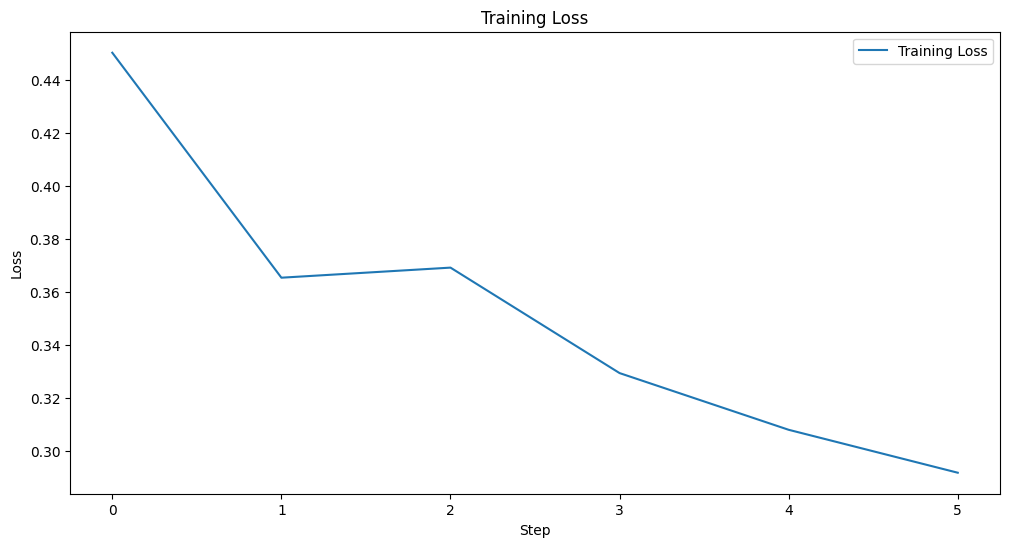

In [8]:
plot_loss(trainer)

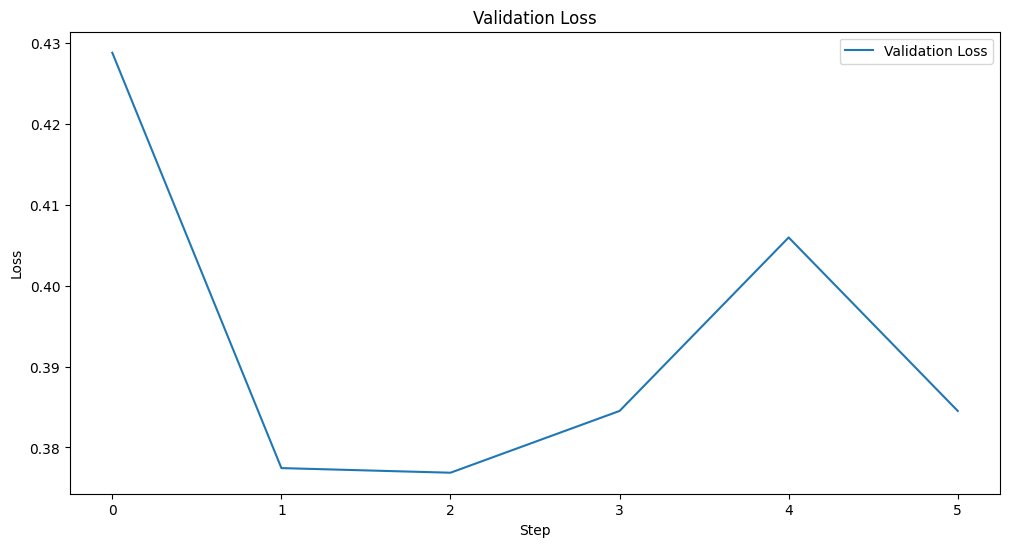

In [9]:
plot_eval_loss(trainer)

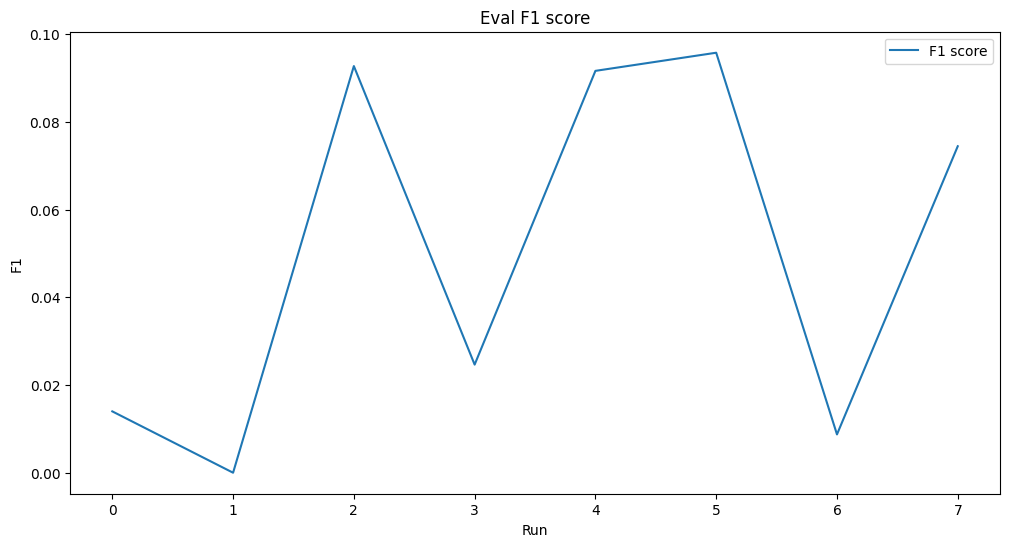

In [10]:
plot_model_progress(full_report)

5. Save weights

In [11]:
trainer.save_model(MODELS_FOLDER / "manipulation-span-detection-ua-model")
tokenizer.save_pretrained(MODELS_FOLDER / "manipulation-span-detection-ua-model")

('/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ua-model/tokenizer_config.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ua-model/special_tokens_map.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ua-model/vocab.txt',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ua-model/added_tokens.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-span-detection-ua-model/tokenizer.json')

6. Test

In [12]:
model = AutoModelForTokenClassification.from_pretrained(
    MODELS_FOLDER / "manipulation-span-detection-ua-model"
)
tokenizer = AutoTokenizer.from_pretrained(MODELS_FOLDER / "manipulation-span-detection-ua-model")

In [13]:
test_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

test_result = test_pipeline(dataset["test"]["content"])

Device set to use mps:0


In [ ]:
visualizer = MarkdownVisualizer(
    tokenizer=tokenizer,
    path=REPORTS_FOLDER
    / "span-detection-ua"
    / "test-visualization"
    / f"test-{epoch_time}.md",
    visualization_mode=VisualizationMode.ROBERTA,
)

visualizer.visualize_as_markdown_and_save(dataset["test"], test_result)